# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk", style='ticks')
import engarde.checks as check

np.random.seed(20090425)

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0, encoding='latin-1')
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = (measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})
                    .drop('AGE', axis=1))

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head(3)

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249


Plot of cumulative cases by district

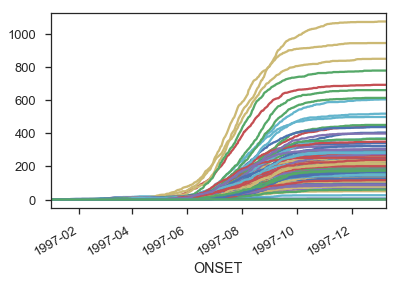

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
measles_data[measles_data.ONSET<'1997-06-15'].shape

(3698, 14)

In [10]:
measles_data[measles_data.ONSET<'1997-07-15'].shape

(11982, 14)

Age distribution of cases, by confirmation status

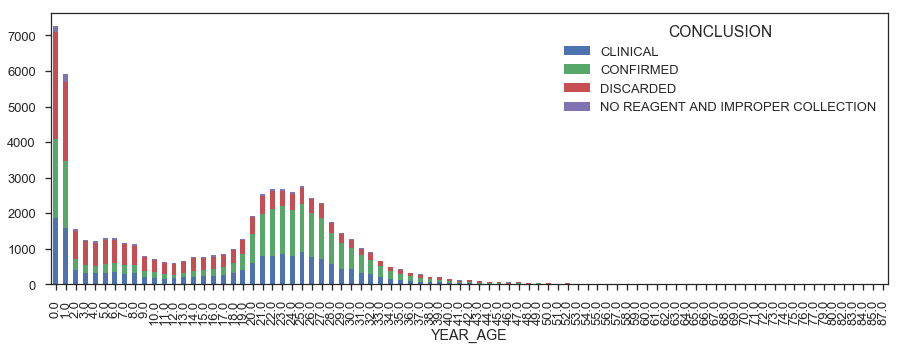

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

### Vaccination Data

In [12]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA,beta_alpha,beta_beta
YEAR,,,,,,
1980,3896442,0.57,121740438,0.0,55.3128,41.7272
1981,3933136,0.73,124610790,0.0,56.8232,21.0168
1982,3952137,0.66,127525420,0.0,58.5816,30.1784
1983,3952735,0.68,130455659,0.0,58.5072,27.5328
1984,3935224,0.73,133364277,0.0,56.8232,21.0168


Calculate residual susceptibility from routine vaccination

In [13]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [14]:
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5

Susceptiblity accounting for SIAs

In [15]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Compilation of cases into 2-week intervals by age class

Age classes are defined in 5-year intervals. We will combine 40+ ages into a single class.

In [16]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.YEAR_AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [17]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract lab-confirmed and clinical-confirmed subsets, with no missing county information.

In [18]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.COUNTY.notnull()].copy()

In [19]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
confirmed = (lab_subset.CONCLUSION=='CONFIRMED').values

In [20]:
clinic_subset = measles_data[CLINICAL & measles_data.COUNTY.notnull()].copy()

Histogram of lab subset, by outcome.

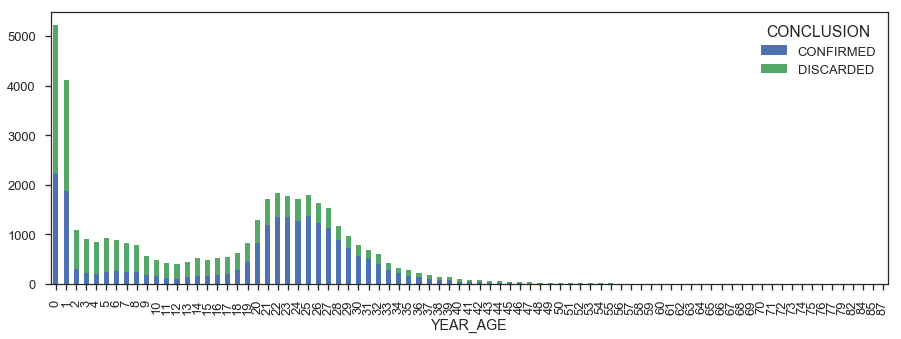

In [21]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [22]:
lab_subset.shape

(41547, 15)

Define age groups

In [23]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

IntervalIndex([[0, 5), [5, 10), [10, 15), [15, 20), [20, 25), [25, 30), [30, 35), [35, 40), [40, 100)]
              closed='left',
              dtype='interval[int64]')

In [24]:
age_slices = [slice(g.left, g.right) for g in age_groups]

Get index from full cross-tabulation to use as index for each district

In [25]:
dates_index = measles_data.groupby(['ONSET', 'AGE_GROUP']).size().unstack().index

## Cleanup of Sao Paulo population data

Match age groupings, exclude invalid districts.

In [26]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [27]:
excludes = ['BOM RETIRO']

N = sp_pop.drop(excludes).loc[unique_districts].sum().drop('Total')

In [28]:
N_age = pd.Series(np.concatenate([N.iloc[:8], [N.iloc[8:].sum()]]), index=age_groups)
N_age

[0, 5)        844130.0
[5, 10)       830880.0
[10, 15)      858750.0
[15, 20)      904972.0
[20, 25)      945244.0
[25, 30)      902086.0
[30, 35)      835888.0
[35, 40)      764605.0
[40, 100)    2841133.0
dtype: float64

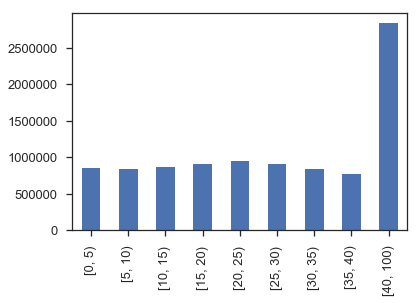

In [29]:
N_age.plot(kind='bar')

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [30]:
# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = (confirmed_data.groupby(['ONSET', 'AGE_GROUP'])
                    .size()
                    .unstack()
                    .reindex(dates_index)
                    .fillna(0)
                    .sum())

all_confirmed_cases = (confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                       .fillna(0).values.astype(int))

In [31]:
confirmed_data.shape

(22097, 15)

In [32]:
confirmed_counts_2w = (confirmed_data
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W')
                        .sum()
                        .pipe(check.is_shape, 
                              (28, len(age_groups)))) 

In [33]:
# All clinical cases, by district
clinical_counts = (clinic_subset.groupby(['ONSET', 'AGE_GROUP'])
                   .size()
                   .unstack()
                   .reindex(dates_index)
                   .fillna(0)
                   .sum())

all_clinical_cases = (clinical_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                      .fillna(0).values.astype(int))

In [34]:
clinical_counts_2w = (clinic_subset
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W')
                        .sum()
                        .pipe(check.is_shape, 
                              (28, len(age_groups)))) 


In [35]:
confirmed_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997-01-19,0.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0
1997-02-02,4.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
1997-02-16,4.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
1997-03-02,9.0,0.0,0.0,2.0,4.0,5.0,1.0,0.0,1.0


In [36]:
clinical_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1997-01-19,30.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,0.0
1997-02-02,22.0,4.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0
1997-02-16,21.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0
1997-03-02,24.0,5.0,2.0,5.0,2.0,2.0,2.0,1.0,0.0


### Mossong contact matrix

Mossong *et al.* (2008) reports contact matrices for several European countries, using the following intervals:

    00-04,05-09,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
    
Here, we will collapse the last few age classes to 40+ and average over all of the countries for use in this model.

In [37]:
belgium = np.reshape([1.36,0.66,0.43,0.28,0.10,0.44,0.80,0.74,0.18,0.22,0.39,0.46,0.34,0.32,0.11,0.74,3.28,0.78,0.68,0.58,0.09,0.68,0.69,0.21,0.06,0.39,0.23,0.07,0.59,0.15,0.42,0.76,5.60,0.81,0.46,0.07,0.34,1.13,0.89,0.26,0.31,0.13,0.10,0.18,0.30,0.14,0.25,1.34,6.39,2.02,0.35,0.55,0.44,0.92,0.76,0.33,0.27,0.07,0.09,0.33,0.34,0.17,0.70,1.67,4.40,0.91,0.84,0.46,0.55,0.80,0.93,0.71,0.27,0.23,0.07,1.08,0.61,0.28,0.72,1.77,2.28,1.16,1.15,0.89,1.08,1.30,1.13,0.54,0.27,0.30,1.46,1.29,0.57,0.37,1.29,1.37,2.07,1.46,0.58,1.06,0.74,1.77,1.20,0.41,0.30,0.77,1.20,1.15,0.73,0.56,1.09,2.18,1.67,1.29,1.46,0.83,1.27,0.76,0.91,0.52,0.38,0.82,1.15,1.15,0.96,0.58,1.57,1.64,1.42,1.00,1.09,1.37,1.07,0.73,0.56,0.26,0.41,0.90,1.27,1.17,1.05,0.77,0.82,1.42,1.98,1.13,1.06,0.83,0.27,0.93,0.41,0.30,0.21,0.51,0.77,0.77,0.59,0.69,0.82,0.86,1.48,1.46,0.51,0.36,0.59,0.39,0.30,0.34,0.20,0.35,0.40,0.86,0.28,0.24,0.72,1.04,1.58,0.88,0.36,0.41,0.24,0.29,0.34,0.09,0.13,0.14,0.39,0.51,0.29,0.18,0.85,0.81,1.41,0.59,0.93,0.16,0.16,0.16,0.13,0.17,0.07,0.32,0.26,0.24,0.38,0.26,0.42,0.88,0.91,0.59,0.23,0.20,0.30,0.15,0.31,0.30,0.43,0.33,0.82,0.92,0.80,1.08,1.12,1.36,1.48],
    (15, 15))

germany = np.reshape([1.90,0.36,0.09,0.04,0.08,0.27,0.46,0.20,0.20,0.09,0.19,0.07,0.10,0.03,0.07,0.81,2.25,0.35,0.18,0.03,0.17,0.26,0.49,0.23,0.09,0.20,0.11,0.14,0.11,0.27,0.34,0.61,3.58,0.69,0.12,0.16,0.14,0.62,0.67,0.35,0.16,0.07,0.07,0.18,0.34,0.42,0.42,0.93,4.19,0.90,0.28,0.19,0.46,1.11,1.21,0.27,0.26,0.11,0.15,0.49,0.56,0.24,0.25,1.29,2.59,1.43,0.44,0.22,0.57,0.45,0.47,0.33,0.19,0.15,0.30,0.62,0.43,0.25,0.36,1.14,1.79,0.98,0.30,0.38,0.57,0.60,0.45,0.32,0.19,0.24,1.20,0.66,0.34,0.22,0.45,1.09,1.49,0.74,0.57,0.59,0.54,0.61,0.31,0.32,0.41,0.87,0.77,0.65,0.60,0.45,0.77,1.18,1.43,0.95,0.70,0.58,0.57,0.36,0.42,0.50,0.49,0.72,0.97,0.69,0.47,0.60,0.98,1.03,1.23,1.05,0.71,0.59,0.49,0.62,0.52,0.40,0.38,0.44,0.68,0.63,0.77,0.32,0.59,0.93,1.23,0.99,0.62,0.44,0.38,0.37,0.38,0.23,0.37,0.39,0.41,0.59,0.67,0.36,0.47,0.82,1.18,0.79,0.40,0.45,0.38,0.26,0.26,0.15,0.26,0.26,0.59,0.35,0.28,0.22,0.41,0.79,1.12,0.75,0.35,0.31,0.27,0.22,0.19,0.12,0.11,0.49,0.42,0.36,0.32,0.28,0.42,0.54,0.85,0.80,0.43,0.19,0.18,0.19,0.15,0.08,0.23,0.19,0.30,0.20,0.15,0.18,0.30,0.52,0.91,0.44,0.38,0.63,0.24,0.14,0.19,0.28,0.21,0.22,0.40,0.26,0.28,0.34,0.37,1.30,
0.76],
    (15, 15))
    
finland = np.reshape([1.97,1.32,0.36,0.30,0.29,0.75,0.92,0.73,0.20,0.23,0.25,0.13,0.40,0.08,0.23,1.09,4.80,1.22,0.36,0.02,0.37,0.43,0.77,0.40,0.39,0.22,0.12,0.18,0.17,0.04,0.40,1.57,8.48,1.55,0.21,0.05,0.42,0.81,0.88,0.63,0.20,0.13,0.08,0.25,0.08,0.21,0.23,1.04,4.56,1.09,0.35,0.10,0.35,0.60,0.66,0.49,0.17,0.08,0.09,0.15,0.18,0.33,0.22,1.09,2.71,1.49,0.70,0.71,0.57,0.89,0.59,0.32,0.27,0.28,0.15,0.71,0.40,0.34,0.51,1.45,2.09,0.95,1.39,0.77,0.55,1.00,0.72,0.45,0.39,0.35,0.88,0.87,0.54,0.44,0.79,1.30,1.57,1.58,0.83,1.00,1.15,0.88,0.69,0.39,0.15,0.84,1.01,0.78,0.58,0.50,1.05,1.25,2.06,1.00,0.84,0.71,0.83,0.69,0.36,0.31,0.60,1.09,1.39,0.72,0.60,0.81,0.88,1.71,2.08,1.45,1.32,1.07,0.63,0.33,0.46,0.49,0.52,0.81,1.17,0.62,0.84,0.90,1.18,1.50,1.33,1.49,0.92,0.47,0.30,0.23,0.44,0.47,0.48,0.53,0.62,1.02,0.80,1.40,1.58,1.13,1.64,1.45,0.60,0.36,0.35,0.33,0.29,0.21,0.39,0.33,0.49,0.78,0.50,0.58,0.55,1.46,1.28,0.82,0.50,0.23,0.38,0.25,0.11,0.11,0.07,0.25,0.52,0.35,0.18,0.42,0.66,0.52,1.27,0.58,0.46,0.19,0.22,0.08,0.07,0.09,0.09,0.13,0.21,0.25,0.13,0.19,0.27,0.53,0.77,0.81,0.15,0.19,0.21,0.15,0.12,0.14,0.25,0.23,0.43,0.30,0.37,0.40,0.60,0.88,1.69],
    (15, 15))
    
uk = np.reshape([1.92,0.65,0.41,0.24,0.46,0.73,0.67,0.83,0.24,0.22,0.36,0.20,0.20,0.26,0.13,0.95,6.64,1.09,0.73,0.61,0.75,0.95,1.39,0.90,0.16,0.30,0.22,0.50,0.48,0.20,0.48,1.31,6.85,1.52,0.27,0.31,0.48,0.76,1.00,0.69,0.32,0.44,0.27,0.41,0.33,0.33,0.34,1.03,6.71,1.58,0.73,0.42,0.56,0.85,1.16,0.70,0.30,0.20,0.48,0.63,0.45,0.30,0.22,0.93,2.59,1.49,0.75,0.63,0.77,0.87,0.88,0.61,0.53,0.37,0.33,0.79,0.66,0.44,0.74,1.29,1.83,0.97,0.71,0.74,0.85,0.88,0.87,0.67,0.74,0.33,0.97,1.07,0.62,0.50,0.88,1.19,1.67,0.89,1.02,0.91,0.92,0.61,0.76,0.63,0.27,1.02,0.98,1.26,1.09,0.76,0.95,1.53,1.50,1.32,1.09,0.83,0.69,1.02,0.96,0.20,0.55,1.00,1.14,0.94,0.73,0.88,0.82,1.23,1.35,1.27,0.89,0.67,0.94,0.81,0.80,0.29,0.54,0.57,0.77,0.97,0.93,0.57,0.80,1.32,1.87,0.61,0.80,0.61,0.59,0.57,0.33,0.38,0.40,0.41,0.44,0.85,0.60,0.61,0.71,0.95,0.74,1.06,0.59,0.56,0.57,0.31,0.21,0.25,0.33,0.39,0.53,0.68,0.53,0.55,0.51,0.82,1.17,0.85,0.85,0.33,0.26,0.25,0.19,0.24,0.19,0.34,0.40,0.39,0.47,0.55,0.41,0.78,0.65,0.85,0.57,0.09,0.11,0.12,0.20,0.19,0.22,0.13,0.30,0.23,0.13,0.21,0.28,0.36,0.70,0.60,0.14,0.15,0.21,0.10,0.24,0.17,0.15,0.41,0.50,0.71,0.53,0.76,0.47,0.74,1.47],
    (15, 15))
    
italy = np.reshape([4.68,1.04,0.20,0.11,0.58,0.11,0.88,0.88,0.75,1.08,0.17,0.43,0.43,0.25,0.23,1.64,9.23,1.25,0.24,0.19,0.24,0.86,0.95,1.00,0.92,1.07,1.12,0.28,0.32,0.33,0.40,1.84,14.56,1.26,0.43,0.34,0.36,0.39,0.92,0.67,3.15,1.31,1.34,0.18,1.43,0.19,0.23,2.59,17.53,1.09,0.82,0.56,0.70,1.31,2.22,2.52,0.43,0.83,0.14,0.97,0.24,0.35,0.65,1.60,4.96,3.42,0.88,0.75,1.19,0.67,0.74,0.80,0.64,0.21,0.37,0.62,0.54,0.46,0.87,3.04,3.45,1.66,1.52,1.14,1.00,1.24,1.18,1.15,0.61,1.10,0.97,0.77,0.52,0.53,1.40,2.97,2.54,2.32,1.95,1.77,1.02,1.18,1.45,1.14,0.93,1.29,1.35,0.95,0.67,1.17,1.55,2.42,3.09,2.05,1.75,1.50,1.31,1.49,1.18,0.57,1.28,1.62,1.72,1.24,1.11,1.24,1.60,3.18,3.10,1.83,1.72,1.65,1.30,0.89,0.97,0.73,0.66,1.40,2.01,1.58,1.08,1.02,1.61,1.97,1.58,1.57,1.41,1.55,1.00,1.00,0.51,0.56,0.84,1.21,1.42,1.00,1.10,1.16,2.02,1.63,1.63,1.39,1.32,0.89,0.77,0.64,0.43,0.42,0.54,0.89,0.92,0.80,0.82,0.73,1.07,1.69,1.84,1.53,0.71,1.03,0.47,0.41,0.18,0.26,0.62,0.53,0.80,0.84,0.98,0.55,0.72,1.31,0.94,1.18,0.73,0.53,0.45,0.37,0.04,0.21,0.26,0.58,0.70,0.51,0.25,0.26,0.84,1.11,1.21,1.27,0.83,0.83,0.71,0.39,0.60,0.79,0.56,0.88,1.07,0.90,0.96,1.57,1.70,1.39,1.27],
    (15, 15))
    
lux = np.reshape([2.34,0.88,0.21,0.19,0.11,0.76,1.48,0.72,0.79,0.61,0.27,0.47,0.52,0.24,0.05,1.05,8.76,1.71,0.25,0.22,1.24,2.24,1.09,1.16,0.28,1.02,0.44,0.35,0.17,0.20,0.48,1.76,11.65,1.64,0.43,0.96,1.24,0.62,1.53,0.66,0.54,0.16,0.15,0.07,0.18,0.18,0.52,2.32,11.78,2.89,1.45,0.70,0.36,1.38,1.87,0.46,1.44,0.28,0.10,0.18,0.35,0.24,0.37,2.13,3.78,1.80,0.85,0.64,0.66,1.34,0.79,0.57,0.52,0.31,0.13,0.79,0.78,0.36,0.92,2.31,3.08,2.48,1.14,1.44,1.30,1.52,1.25,0.91,0.69,0.33,1.30,0.94,0.66,0.78,1.48,2.17,3.48,1.72,2.56,1.81,1.65,1.29,1.40,1.03,0.45,1.45,1.79,1.14,0.94,1.41,1.90,3.11,2.59,2.72,1.75,1.63,1.03,1.28,1.41,0.50,0.83,1.29,1.60,1.36,1.19,1.41,2.48,2.36,3.54,1.63,1.90,1.09,1.14,1.17,0.65,0.37,0.57,1.02,1.36,1.67,1.11,1.48,1.84,2.37,2.46,1.97,1.04,0.80,0.69,0.43,0.33,0.37,0.43,0.69,1.28,1.38,1.24,1.00,1.37,2.03,2.13,1.06,0.94,0.93,0.35,0.33,0.33,0.31,0.40,0.52,1.06,0.78,0.74,0.62,0.78,1.19,1.09,0.95,1.07,0.38,0.40,0.24,0.16,0.13,0.24,0.54,0.28,0.62,0.46,0.46,0.67,0.65,1.12,1.07,0.60,0.23,0.12,0.21,0.10,0.20,0.27,0.41,0.31,0.50,0.36,0.33,0.43,0.80,1.17,0.58,0.28,0.27,0.29,0.28,0.43,0.58,0.48,0.26,0.72,0.93,1.40,0.64,1.11,0.93,1.75],
    (15, 15))

holland = np.reshape([3.50,1.71,0.25,0.19,0.33,0.57,1.00,0.92,3.00,0.00,0.00,0.23,0.39,0.12,0.22,2.47,11.88,1.56,0.19,0.00,0.50,1.25,1.62,1.14,0.71,0.31,0.08,0.28,0.24,0.29,0.32,1.06,10.97,2.50,0.08,0.00,1.50,1.00,0.71,0.93,0.08,0.31,0.22,0.06,0.20,0.15,0.24,1.44,9.19,0.83,0.29,1.25,0.08,0.57,0.79,0.46,0.46,0.39,0.00,0.24,0.24,0.18,0.16,1.25,2.42,0.57,0.75,0.85,2.29,0.71,2.23,0.85,0.50,0.29,0.29,0.21,0.88,0.13,0.44,1.58,1.86,2.25,0.62,0.86,1.21,1.85,0.38,0.56,0.41,0.32,1.26,0.71,0.25,0.44,2.67,1.00,3.75,1.00,1.71,0.86,0.85,0.92,0.94,0.18,0.49,1.15,1.53,0.78,0.75,1.58,0.86,3.00,3.92,1.29,1.79,1.23,0.69,1.17,0.59,0.71,0.53,1.76,1.56,0.69,0.67,1.07,2.13,3.08,1.86,2.50,0.38,1.54,0.78,0.65,0.71,0.24,0.47,0.94,1.38,0.92,0.50,1.63,1.69,1.29,2.21,1.23,1.00,0.61,0.35,1.24,0.47,0.47,0.56,0.69,0.83,1.21,0.88,1.62,1.14,1.50,1.31,1.23,1.17,0.24,0.51,0.38,0.24,0.19,0.31,0.25,0.57,0.25,0.46,0.00,0.93,0.69,2.38,1.67,0.71,0.51,0.35,0.41,0.03,0.06,0.08,0.29,0.50,0.92,0.14,0.43,0.38,1.15,1.61,1.12,0.46,0.29,0.29,0.13,0.13,0.00,0.14,0.13,0.69,0.14,0.00,0.31,0.69,0.72,0.82,0.46,0.24,0.24,0.56,0.56,0.33,0.21,0.63,0.46,0.00,0.79,0.62,0.23,1.11,1.00,1.95],
    (15, 15))
    
poland = np.reshape([1.33,0.57,0.21,0.10,0.21,0.40,0.38,0.23,0.11,0.13,0.31,0.23,0.25,0.20,0.23,0.83,6.41,1.06,0.29,0.10,0.27,0.74,0.77,0.56,0.16,0.24,0.50,0.27,0.44,0.26,0.75,1.62,12.71,1.01,0.30,0.25,0.80,0.68,0.69,0.26,0.37,0.42,0.25,0.44,0.34,0.49,0.41,2.27,12.12,2.13,0.72,0.54,1.29,1.18,1.13,0.94,0.66,0.53,0.60,0.40,0.69,0.36,0.63,1.69,6.26,2.40,1.16,1.40,1.58,1.44,1.45,1.02,0.66,0.60,0.34,1.36,0.92,0.84,0.80,2.61,3.43,2.28,2.50,1.81,1.75,1.94,1.37,1.10,1.36,0.26,1.19,1.42,1.19,0.88,1.59,2.18,2.36,2.68,1.77,1.44,1.61,1.34,1.31,1.40,0.46,0.85,0.96,1.23,1.06,1.13,1.43,1.64,3.08,1.76,1.33,1.24,1.06,1.02,1.08,0.71,0.44,0.68,0.96,1.17,1.11,1.37,1.44,1.87,2.47,1.49,1.71,0.98,1.07,1.68,0.74,0.47,0.59,0.71,0.96,0.98,1.12,1.36,1.52,1.56,2.25,1.74,1.16,0.56,0.92,0.83,0.57,0.47,0.46,0.51,1.20,1.33,1.11,1.05,1.03,1.56,1.58,1.40,0.56,0.96,0.74,0.53,0.48,0.28,0.25,0.79,0.77,0.56,0.87,0.68,0.61,0.94,1.95,1.10,0.68,0.54,0.29,0.32,0.24,0.25,0.34,0.45,0.59,0.58,0.56,0.41,0.52,0.84,1.12,0.48,0.57,0.26,0.18,0.15,0.20,0.10,0.23,0.18,0.53,0.34,0.31,0.19,0.56,0.64,0.72,0.54,0.28,0.36,0.38,0.23,0.30,0.40,0.30,0.71,0.55,0.67,0.71,0.77,0.64,0.80,1.23],
    (15, 15))

mossong_B  = (belgium + germany + finland + uk + italy + lux + holland + poland) / 8

In [38]:
B = mossong_B[:9, :9]

In [39]:
evs = np.linalg.eigvals(B).real
max(evs[np.isreal(evs)])

12.84779748740738

## Stochastic Disease Transmission Model

We will extend a simple SIR disease model, to account for confirmation status, which will be fit using MCMC.

This model fits the series of 2-week infection totals for each age group $a$ as a set of Poisson random variables:

\\[Pr(I_{a}(t) | \lambda_a(t)) = \text{Poisson}(\lambda_a(t)) \\]

Where the age-specific outbreak intensity at time $t$ is modeled as:

\\[\lambda_a(t) = S_a(t-1) \frac{I(t-1)\mathbf{B}}{N_a} \\]

where $S_a(t-1)$ is the number of susceptibles in age group $a$ in the previous time period, $I(t-1)$ an age-specific vector of the number of infected individuals in the previous time period, $\mathbf{B}$ a matrix of transmission coefficients (both within- and between-ages), and $N_a$ an estimate of the population of age-$a$ people in Sao Paulo.

The matrix $B$ was constructed from a scalar transmission parameter $\beta$, which was given a vague half-Cauchy prior (scale=25). This was used to represent within-age-group transmission, and hence placed on the diagonal of a square transmission matrix of size $A$. Off-diagonal elements, representing transmission between age groups were scaled by a decay parameter $\delta$ which was used to scale the transmission to adjacent groups according to:

\\[\beta \delta^{|a-b|}\\]

where a and b are indices of two age group. The resulting transmission matrix is parameterized as follows:

$$\begin{aligned}
\mathbf{B} = \left[{
\begin{array}{c}
  {\beta} & {\beta \delta} & {\beta \delta^2}& \ldots & {\beta \delta^{A-2}} & {\beta \delta^{A-1}}  \\
  {\beta \delta} & {\beta} &  \beta \delta & \ldots & {\beta \delta^{A-3}}  & {\beta \delta^{A-2}} \\
  {\beta \delta^2} & \beta \delta & {\beta} & \ldots & {\beta \delta^{A-4}} & {\beta \delta^{A-3}} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {\beta \delta^{A-2}} & {\beta \delta^{A-3}} & {\beta \delta^{A-4}} & \ldots &  {\beta} & \beta \delta  \\
{\beta \delta^{A-1}} & {\beta \delta^{A-2}} & \beta \delta^{A-3} & \ldots & \beta \delta &  {\beta} 
\end{array}
}\right]
\end{aligned}$$

The basic reproductive number $R_0$ was calculated as the largest real-valued eigenvalue of the matrix $\mathbf{B}$. To impose a mild constraint on $R_0$, we applied a Gaussian prior distribution whose 1st and 99th quantiles are 8 and 24, respectively, a reasonable range for a measles outbreak:

In [65]:
from pymc import MCMC, Matplot, AdaptiveMetropolis, MAP, Slicer
from pymc import (Uniform, DiscreteUniform, Beta, Binomial, Normal, 
                  CompletedDirichlet, Pareto, Wishart,
                  Poisson, NegativeBinomial, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like,
                  TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  MvNormalCov, Bernoulli, Uninformative, 
                  Multinomial, rmultinomial, rbinomial,
                  Dirichlet, multinomial_like, uniform_like)
from pymc import (Lambda, observed, invlogit, deterministic, potential, stochastic, logit)

alphas, betas = vaccination_data[['beta_alpha', 'beta_beta']].values.T

def measles_model(obs_date, confirmation=True, migrant=False, constrain_R=True, vax_uncertainty=False):
    
    
    '''
    Truncate data at observation period
    '''
    obs_index = clinical_counts_2w.index <= obs_date
    confirmed_obs_t = confirmed_counts_2w[obs_index].values.astype(int)
    clinical_obs_t = clinical_counts_2w[obs_index].values.astype(int)
                        
    n_periods, n_age_groups = confirmed_obs_t.shape

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    lab_index = (lab_subset.NOTIFICATION > obs_date).values
    confirmed_t = confirmed[lab_index]
    age_index_t = age_index[lab_index]
    
    '''
    Confirmation sub-model
    '''
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        μ = Normal("μ", mu=0, tau=0.0001, value=[0]*len(age_classes))
        σ = HalfCauchy('σ', 0, 25, value=1)
        var = σ**2
        ρ = Uniform('ρ', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Σ(var=var, cor=ρ):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        β_age = MvNormalCov("β_age", mu=μ, C=Σ, value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda b=β_age: invlogit(b))

        @deterministic(trace=False)
        def p_confirm(b=β_age):
            return invlogit(b[age_index_t])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=confirmed_t, 
                                observed=True)

    if confirmation:
        
        @stochastic(dtype=int)
        def clinical_cases(value=(clinical_obs_t*0.5).astype(int), 
                            n=clinical_obs_t, p=p_age):
            # Binomial confirmation process
            return np.sum([binomial_like(xi, ni, p) for xi,ni in zip(value,n)])
        I = Lambda('I', lambda clinical=clinical_cases: 
                           clinical + confirmed_obs_t.astype(int))

        assert I.value.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I.value, 0)/ float(I.value.sum())
        
    else:
        
        I = confirmed_obs_t + clinical_obs_t

        assert I.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I, 0) / float(I.sum())
        
    
    # Calcuate age distribution from observed distribution of infecteds to date
    _age_dist = Dirichlet('_age_dist', np.ones(n_age_groups), 
                         value=age_dist_init[:-1]/age_dist_init.sum())
    age_dist = CompletedDirichlet('age_dist', _age_dist)
    
    @potential
    def age_dist_like(p=age_dist, I=I):
        return multinomial_like(I.sum(0), I.sum(), p)

    
    '''
    Disease transmission model
    '''

    # Transmission parameter
#     β = HalfCauchy('β', 0, 25, value=5) #[1]*n_age_groups) 
#     decay = Beta('decay', 1, 5, value=0.8)

#     @deterministic
#     def B(b=β, d=decay):
#         b = np.ones(n_age_groups)*b
#         B = b*np.eye(n_age_groups)
#         for i in range(1, n_age_groups):
#             B += np.diag(np.ones(n_age_groups-i)*b[i:]*d**i, k=-i) 
#             B += np.diag(np.ones(n_age_groups-i)*b[:-i]*d**i, k=i)
#         return B

    _B = Wishart('_B', n=n_age_groups, Tau=np.eye(n_age_groups))
    B = Lambda('B', lambda B=_B: np.abs(B))
    print(B.value)

    # Downsample annual series to observed age groups
    downsample = lambda x: np.array([x[s].mean() for s in age_slices])

    @deterministic
    def R0(B=B):
        evs = np.linalg.eigvals(B)
        return max(evs[np.isreal(evs)])
    
    if constrain_R:
        @potential
        def constrain_R0(R0=R0):
            # Weakly-informative prior to constrain R0 to be within the 
            # typical measles range
            return normal_like(R0, 16, 3.4**-2)


    A = Lambda('A', lambda R0=R0: 75./(R0 - 1))
    
    if vax_uncertainty:
        
        vax = Beta('vax', alphas[:17], betas[:17], value=vaccination_data.VAX[:17])

        vax_97 = Lambda('vax_97', lambda vax=vax: np.r_[[0]*(1979-1921+1), vax])

        n = len(vax_97.value)

        FOI_mat = Lambda('FOI_mat', lambda vax_97=vax_97: np.resize((1 - vax_97*0.9), (n,n)).T)

        @deterministic
        def vacc_susc(vax_97=vax_97):
            v = (1 - vax_97*0.9)[::-1]
            v[0] = 0.5
            return v

        coverage_residual = Uniform('coverage_residual', 0.2, 0.325)

        @deterministic
        def sia_susc(r=coverage_residual):
            s = np.ones(n)
            birth_year = np.arange(1922, 1998)[::-1]
            by_mask = (birth_year > 1983) & (birth_year < 1992)
            s[by_mask] *= r
            return s

        lt_sum = Lambda('lt_sum', lambda FOI_mat=FOI_mat: downsample(np.tril(FOI_mat).sum(0)[::-1]))
        natural_susc = Lambda('natural_susc', lambda A=A, lt_sum=lt_sum: np.exp((-1/A) * lt_sum))
    
    else:
        lt_sum = downsample(np.tril(FOI_mat).sum(0)[::-1])
        natural_susc = Lambda('natural_susc', lambda A=A: np.exp((-1/A) * lt_sum))

    @deterministic
    def p_μ(v=vacc_susc, n=natural_susc, s=sia_susc): 
        return downsample(s) * downsample(v) * n
    
    # Following Stan manual chapter 16.2
    λ_p = Pareto('λ_p', 1.5, 0.1, value=0.5)

    a = Lambda('a', lambda mu=p_μ, lam=λ_p: mu*lam, trace=False)
    b = Lambda('b', lambda mu=p_μ, lam=λ_p: (1-mu)*lam, trace=False)

    p_susceptible = Beta('p_susceptible', a, b, value=p_μ.value)

    # Estimated total initial susceptibles
    if not migrant:
        S_0_init = (N_age.values*p_μ.value).astype(int) + 30
        S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible, value=S_0_init)
    else:
        S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible)
    
    '''
    Model of migrant influx of susceptibles
    '''
    if migrant:
    
        # Data augmentation for migrant susceptibles
        imaginary_migrants = 1000000
        N_migrant = DiscreteUniform('N_migrant', 0, imaginary_migrants, value=100000)
        μ_age = Uniform('μ_age', 15, 35, value=25)
        σ_age = Uniform('σ_age', 1, 10, value=5)
        M_age = Normal('M_age', μ_age, σ_age**-2, 
                       size=imaginary_migrants, trace=False)

        @deterministic
        def M_0(M=M_age, N=N_migrant):
            # Take first N augmented susceptibles
            M_real = M[:N]
            # Drop into age groups
            M_group = pd.cut(M_real, 
                             [0, 5, 10, 15, 20, 25, 30, 35, 40, 100], 
                             right=False)
            return M_group.value_counts().values

        p_migrant = Lambda('p_migrant', lambda M_0=M_0, S_0=S_0: M_0/(M_0 + S_0))

        I_migrant = [Binomial('I_migrant_%i' % i, I[i], p_migrant) 
                             for i in range(t_obs + 1)]

        I_local = Lambda('I_local', 
                lambda I=I, I_m=I_migrant: 
                         np.array([Ii - Imi for Ii,Imi in zip(I,I_m)]))
        S = Lambda('S', lambda I=I, S_0=S_0, M_0=M_0: S_0 + M_0 - I.cumsum(0))
        S_local = Lambda('S_local', lambda I=I_local, S_0=S_0: S_0 - I.cumsum(0))


    else:

        # Remaining susceptibles at each 2-week period
        S = Lambda('S', lambda I=I, S_0=S_0: S_0 - I.cumsum(axis=0))
    
    # Check shape
    assert S.value.shape == (t_obs+1., n_age_groups)
    
    # Susceptibles at time t, by age
    S_age = Lambda('S_age', lambda S=S: S[-1].astype(int))

    # Force of infection
    @deterministic
    def λ(B=B, I=I, S=S): 
        import pdb;pdb.set_trace()
        return S * (I.dot(B) / N_age.values)

    # Check shape
    assert λ.value.shape == (t_obs+1, n_age_groups)
    
    
    # FOI in observation period
    λ_t = Lambda('λ_t', lambda lam=λ: lam[-1])
    
    # Effective reproductive number
    R_t = Lambda('R_t', lambda S=S, R0=R0: S.sum(1) * R0 / N_age.sum())
    
    if migrant:
        R_t_local = Lambda('R_t_local', lambda S=S_local, R0=R0: S.sum(1) * R0 / N_age.sum())
    
    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, lam=λ):
        return poisson_like(I[1:], lam[:-1])
    
    '''
    Vaccination targets
    '''
    
    # Probability of vaccine efficacy
    p_efficacy = 0.95
    # Reach of campaign
    p_reach = 0.9
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 5 and under
        p = [p_reach] + [0]*(n_age_groups - 1)
        return rbinomial(rbinomial(S, p), p_efficacy)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', 
                lambda V=vacc_5, S=S_age: V.sum()/S.sum())


    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [p_reach]*3 + [0]*(n_age_groups - 3)
        return rbinomial(rbinomial(S, p), p_efficacy)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', 
            lambda V=vacc_15, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [p_reach]*6 + [0]*(n_age_groups - 6)
        return rbinomial(rbinomial(S, p), p_efficacy)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', 
            lambda V=vacc_30, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [p_reach, 0, 0, 0, p_reach, p_reach] + [0]*(n_age_groups - 6)
        return rbinomial(rbinomial(S, p), p_efficacy)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', 
            lambda V=vacc_adult, S=S_age: V.sum()/S.sum())

    return locals()

## Model execution

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [66]:
n_iterations = 50000
n_burn = 40000
migrant = True

Use `backgroundjobs` to run the models each in their own thread:

In [67]:
from IPython.lib import backgroundjobs as bg

jobs = bg.BackgroundJobManager()

Instantiate models

In [ ]:
model_june = MCMC(measles_model('1997-06-15', confirmation=True, migrant=migrant, vax_uncertainty=True))
model_july = MCMC(measles_model('1997-07-15', confirmation=True, migrant=migrant, vax_uncertainty=True))
model_june_noconf = MCMC(measles_model('1997-06-15', confirmation=False, migrant=migrant, vax_uncertainty=True))
model_july_noconf = MCMC(measles_model('1997-07-15', confirmation=False, migrant=migrant, vax_uncertainty=True))

[[  6.27237595   0.88118004   2.80588977   1.54380067   2.3171573
    0.1729035    1.45049247   5.41185338   0.85985465]
 [  0.88118004  12.22289638   2.43205028   4.78843991   1.95384824
    3.29426632   1.71031416   2.71519141   5.38095785]
 [  2.80588977   2.43205028   5.78683621   2.11439386   3.66695372
    1.34402822   1.88470663   5.87564199   2.65234941]
 [  1.54380067   4.78843991   2.11439386   4.60124226   1.43633459
    1.27068348   1.53922177   1.72208014   4.81848307]
 [  2.3171573    1.95384824   3.66695372   1.43633459   7.88492176
    3.75666797   2.32901022   1.92188997   4.38582921]
 [  0.1729035    3.29426632   1.34402822   1.27068348   3.75666797
    9.60462265   0.35895156   3.12819961   0.69616238]
 [  1.45049247   1.71031416   1.88470663   1.53922177   2.32901022
    0.35895156   6.81227158   1.53378664   2.24276207]
 [  5.41185338   2.71519141   5.87564199   1.72208014   1.92188997
    3.12819961   1.53378664  11.37780744   2.64608178]
 [  0.85985465   5.380957

Run models

In [114]:
for model in model_june, model_july, model_june_noconf, model_july_noconf:
    jobs.new(model.sample, n_iterations, n_burn, kw=dict(progress_bar=False))

Starting job # 0 in a separate thread.
Starting job # 2 in a separate thread.
Starting job # 3 in a separate thread.
Starting job # 4 in a separate thread.


In [117]:
jobs.status()

Completed jobs:
0 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x123067588>>
2 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x1be1d6128>>
3 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x1bddc0278>>
4 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x1bddbc898>>



## Summary of model output

Estimate of R0 for june (with confirmation submodel)

In [118]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june.R0)

AttributeError: 'numpy.float64' object has no attribute 'value'

Estimate of R0 for june (no confirmation submodel)

Plotting R0


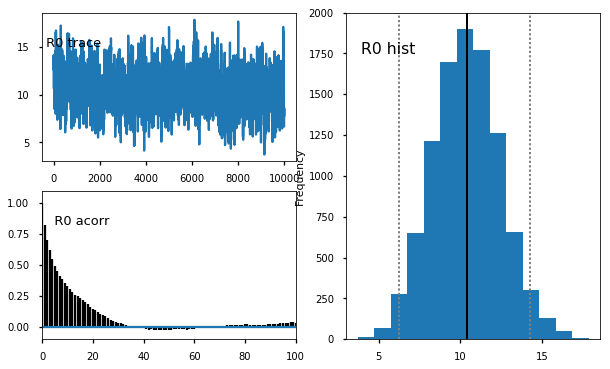

In [63]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june_noconf.R0)

Estimate of R0 for july (with confirmation submodel)

Plotting R0


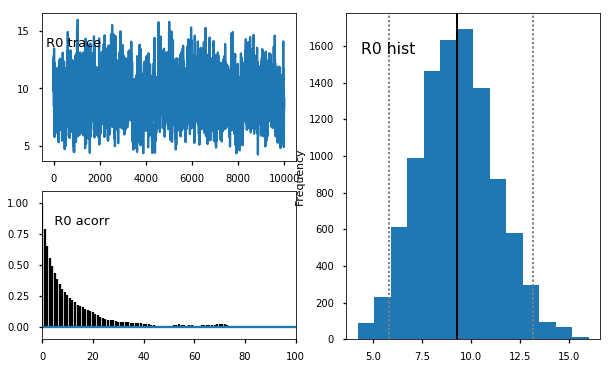

In [64]:
if model_july.R0.shape:
    Matplot.summary_plot(model_july.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july.R0)

Estimate of R0 for july (no confirmation submodel)

Plotting R0


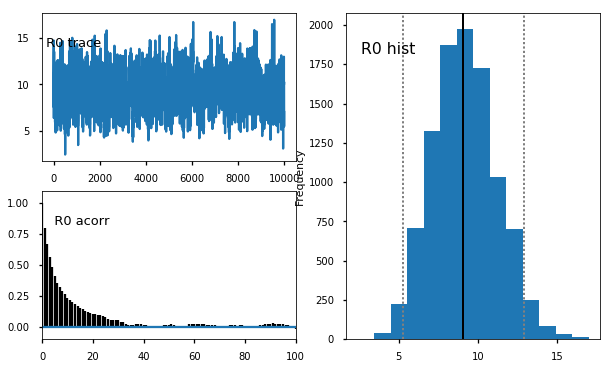

In [65]:
if model_july_noconf.R0.shape:
    Matplot.summary_plot(model_july_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july_noconf.R0)

Lab confirmation rates, June model

In [119]:
model_june.p_age.trace().shape

(10000, 9)

In [120]:
age_group_labels = [str(v) for v in age_groups.values]

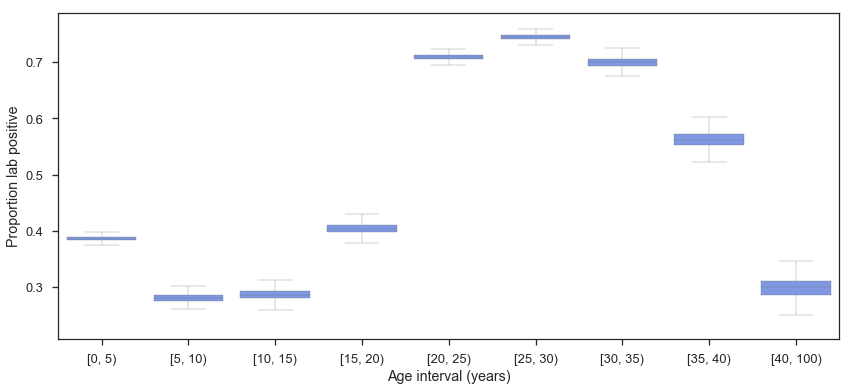

In [121]:
with sns.axes_style("ticks"):

    p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

    f, axes = plt.subplots(figsize=(14,6))
    sns.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
              color=sns.color_palette("coolwarm", 5)[0])
    axes.set_ylabel('Proportion lab positive')
    axes.set_xlabel('Age interval (years)')

Proportion of **local** population susceptible, June model.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


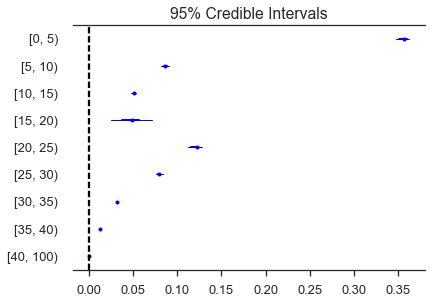

In [122]:
Matplot.summary_plot(model_june.p_susceptible, custom_labels=age_group_labels)

Proportion of **local** population susceptible, June model with no confirmation correction

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


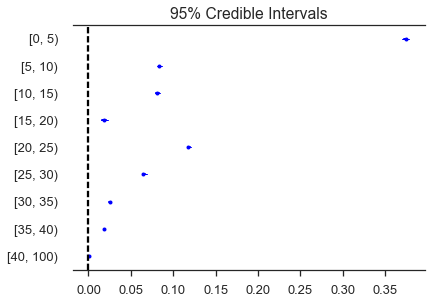

In [123]:
Matplot.summary_plot(model_june_noconf.p_susceptible, custom_labels=age_group_labels)

Epidemic intensity estimates at June or July observation time, by age group.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


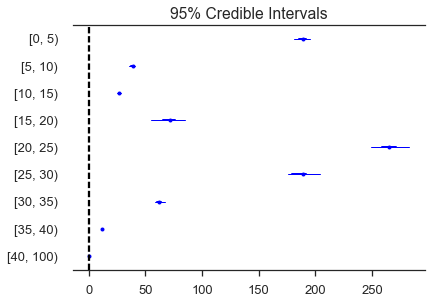

In [124]:
Matplot.summary_plot(model_june.λ_t, custom_labels=age_group_labels)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


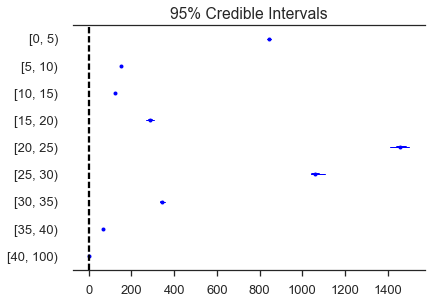

In [125]:
Matplot.summary_plot(model_july.λ_t, custom_labels=age_group_labels)

Time series of epidemic intensities for lab- versus clinical-confirmation models, for each age group.

In [126]:
model_june.λ_t.trace().std()

89.265376478890659

In [127]:
lam_june = model_june.λ_t.stats()

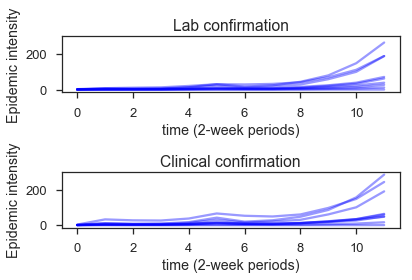

In [128]:
lam_june = model_june.λ.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50], 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.λ.stats()

axes[1].plot(lam_june_noconf['quantiles'][50], 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')

plt.tight_layout()

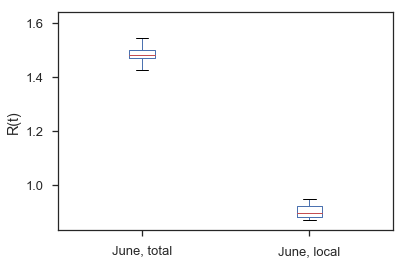

In [129]:
Rt_values = pd.DataFrame(np.c_[model_june.R_t.trace()[:, -1],
                          model_june.R_t_local.trace()[:, -1]],
                        columns=['June, total', 'June, local'])

ax = Rt_values.boxplot(return_type='axes', grid=False);
ax.set_ylabel('R(t)')

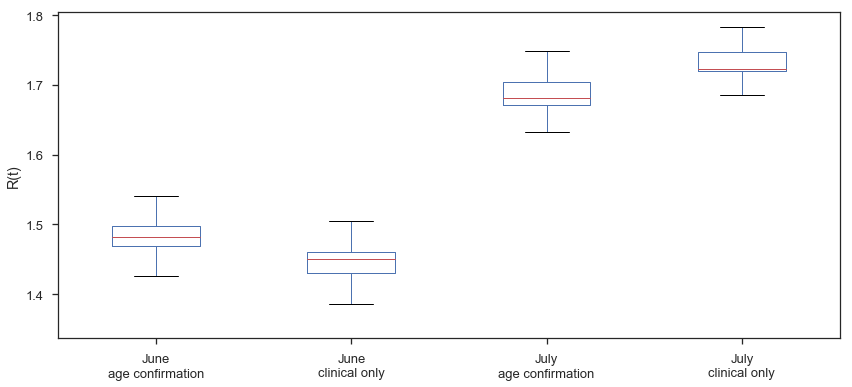

In [130]:
with sns.axes_style("ticks"):
    
    Rt_values = pd.DataFrame(np.c_[model_june.R_t.trace()[:, -1],
                              model_june_noconf.R_t.trace()[:, -1],
                             model_july.R_t.trace()[:, -1],
                             model_july_noconf.R_t.trace()[:, -1]],
                            columns=['June\nage confirmation', 'June\nclinical only',
                                    'July\nage confirmation', 'July\nclinical only'])

    ax = Rt_values.boxplot(return_type='axes', figsize=(14,6), grid=False);
    ax.set_ylabel('R(t)')

In [131]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'
S_age_june['Month'] = 'June'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'
S_age_june_noconf['Month'] = 'June'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)
S_age_june.to_csv('output/S_age_june.csv')

In [132]:
S_age_june_local = pd.DataFrame(model_june.S_local.trace()[:,-1,:].squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_local.columns = 'Age', 'Iteration', 'S'
S_age_june_local['Confirmation'] = 'Lab'
S_age_june_local['Month'] = 'June'

S_age_june_local_noconf = pd.DataFrame(model_june_noconf.S_local.trace()[:,-1,:].squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_local_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_local_noconf['Confirmation'] = 'Clinical'
S_age_june_local_noconf['Month'] = 'June'

S_age_june_local = pd.concat([S_age_june_local, S_age_june_local_noconf], ignore_index=True)
S_age_june_local.to_csv('output/S_age_june_local.csv')

In [133]:
S_age_july = pd.DataFrame(model_july.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'
S_age_july['Month'] = 'July'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'
S_age_july_noconf['Month'] = 'July'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)
S_age_july.to_csv('output/S_age_july.csv')

In [134]:
S_age = pd.concat([S_age_june.assign(susceptibles='Migrant + Local'), 
                   S_age_june_local.assign(susceptibles='Local only')], ignore_index=True)
S_age.to_csv('output/S_age.csv')

Numbers of suscepibles in each age group, under lab vs clinical confirmation

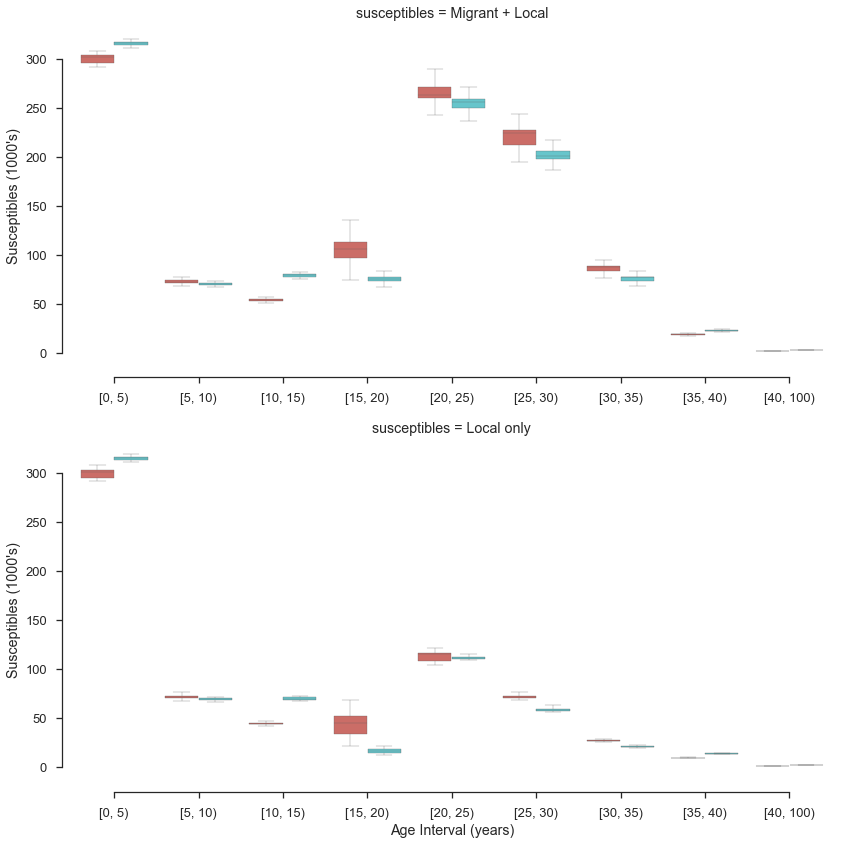

In [135]:
sns.despine()

with sns.axes_style("ticks"):
    
    g = sns.factorplot("Age", "S1000", "Confirmation", data=S_age.assign(S1000=S_age.S/1000), 
                      kind="box", palette="hls", row='susceptibles', size=6, aspect=2, linewidth=0.3, fliersize=0, 
                      order=age_group.categories, legend=False)#, facet_kws={'ylim':(0, 250)})
    g.despine(offset=10, trim=True)
    g.set_axis_labels("Age Interval (years)", "Susceptibles (1000's)")
    plt.tight_layout();

### Vaccination coverage by strategy

In [136]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.228            0.006            0.0              [ 0.22   0.242]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.218            0.223           0.23           0.232         0.241
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.324            0.007            0.0              [ 0.315  0.341]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.312            0.318           0.326          0.328         0.34
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------

In [137]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [138]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [139]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

coverage.to_csv('output/coverage.csv')

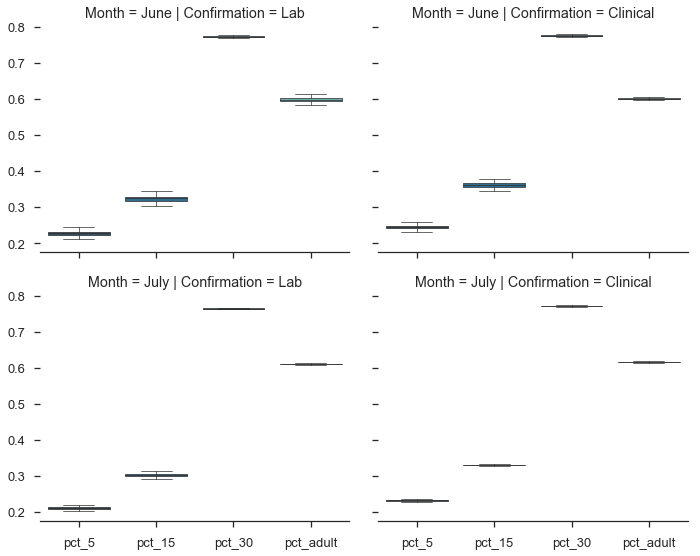

In [140]:
sns.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

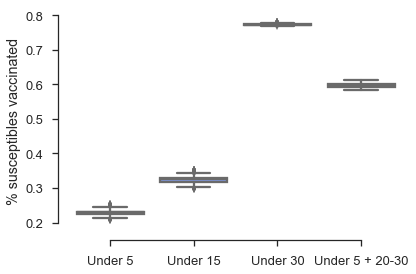

In [141]:
axes = sns.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sns.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sns.despine(offset=10, trim=True)

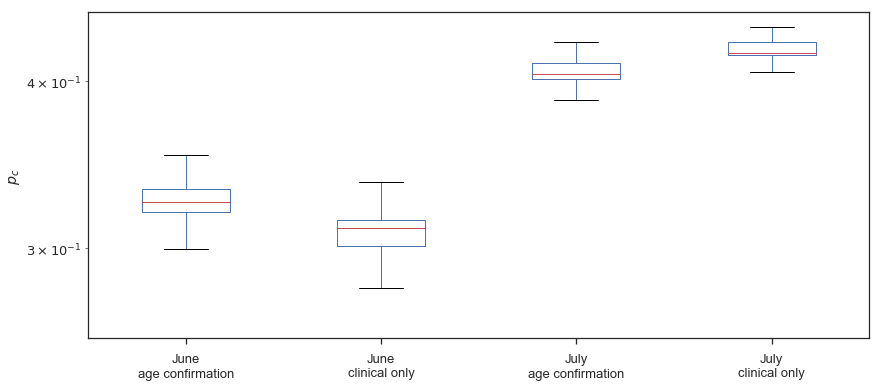

In [142]:
with sns.axes_style("ticks"):
    pc_values = np.maximum(0, 1- 1/Rt_values)
    ax = pc_values.boxplot(return_type='axes', figsize=(14,6), grid=False)
    ax.set_ylabel('$p_c$')
    ax.semilogy();

In [143]:
qcoverage = coverage.groupby(['Month','Confirmation'], sort=False).quantile([0.025, 0.975])
qcoverage

pct_15    pct_30     pct_5  pct_adult
Month Confirmation                                               
June  Lab          0.025  0.311905  0.770521  0.218350   0.585957
                   0.975  0.339878  0.777162  0.241197   0.611653
      Clinical     0.025  0.348677  0.773296  0.236502   0.598129
                   0.975  0.375895  0.778659  0.255244   0.603950
July  Lab          0.025  0.296650  0.763051  0.206757   0.608765
                   0.975  0.310562  0.765616  0.217068   0.613165
      Clinical     0.025  0.325481  0.770234  0.228008   0.614978
                   0.975  0.337204  0.774023  0.237889   0.618579

In [144]:
mean_coverage = coverage.groupby(['Month','Confirmation'], sort=False).mean()
mean_coverage

pct_15    pct_30     pct_5  pct_adult
Month Confirmation                                         
June  Lab           0.324423  0.773750  0.228438   0.597905
      Clinical      0.361864  0.775780  0.245863   0.601339
July  Lab           0.303085  0.764364  0.211419   0.610691
      Clinical      0.331341  0.771915  0.232754   0.616682

In [145]:
label_lookup = dict(zip(['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
    ['Under 5', 'Under 15', 'Under 30', 'Adults & young kids']))

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


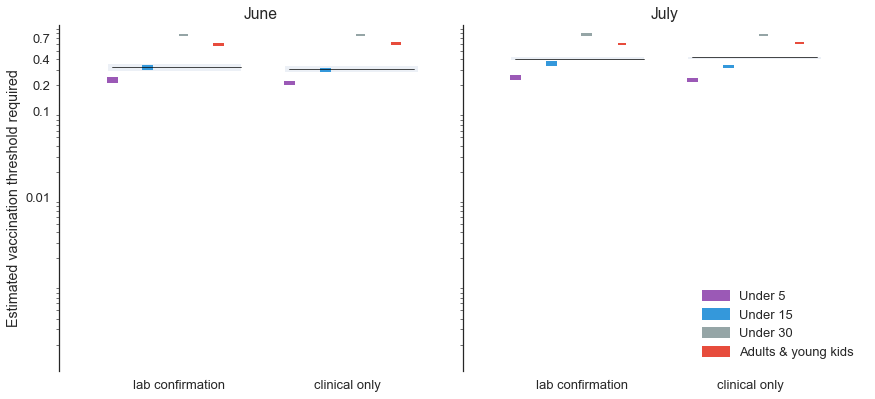

In [146]:
from matplotlib.patches import Rectangle

plot_interval = True

with sns.axes_style("ticks"):
    
    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
    
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.8])
    ax1.semilogy()
    ax2 = fig.add_axes([0.5, 0.1, 0.4, 0.8])
    ax2.semilogy()
    
    q = pc_values.quantile([0.025, 0.975]).values + 1e-8
    m = pc_values.mean().values
    
    months = ['June', 'July']
    
    for i,ax in enumerate([ax1, ax2]):
        ax.set_yticks([0.01, 0.1, 0.2, 0.4, 0.7])
        ax.set_yticklabels([0.01, 0.1, 0.2, 0.4, 0.7])
        ax.set_ybound(0.0001, .999)
        
        ax.set_xticks([0.08, 0.27, 0.4])
        ax.set_xticklabels(['lab confirmation', 'clinical only'])
        
        ax.tick_params(length=0)
        
        ax.set_title(months[i])
                
        ax.add_patch(Rectangle((0.0, q[0, 2*i]), 0.15, q[1, 2*i]-q[0, 2*i], alpha=0.1))
        ax.add_patch(Rectangle((0.2, q[0, 1+2*i]), 0.15, q[1, 1+2*i]-q[0, 1+2*i], alpha=0.1))
        
        # Add estimates
        conf = ('Lab', 'Clinical')
        handles = []
        for j, pct in enumerate(['pct_5', 'pct_15', 'pct_30', 'pct_adult']):
            
            interval = qcoverage.ix[('June', conf[i])]
            ax.add_patch(Rectangle((0.04*j, interval.loc[0.025, pct]), 
                                   0.01, interval.loc[0.975, pct]-interval.loc[0.025, pct], 
                                   lw=2, 
                                   color=colors[j]))

            interval = qcoverage.ix[('July', conf[i])]
            rect = Rectangle((0.04*j + 0.2, interval.loc[0.025, pct]), 
                                   0.01, interval.loc[0.975, pct]-interval.loc[0.025, pct],
                                   lw=2, label=label_lookup[pct],
                                   color=colors[j])
            ax.add_patch(rect)
            handles.append(rect)
        
        
        ax.axhline(m[2*i], 0.13, 0.45, color='black', lw=0.7)
        ax.axhline(m[1+2*i], 0.57, 0.88, color='black', lw=0.7)

    ax2.set_yticks([])
    ax1.set_ylabel('Estimated vaccination threshold required')
    
    ax2.legend(handles=handles, loc=4)
    
    sns.despine(bottom=True)

In [147]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.246            0.005            0.0              [ 0.237  0.255]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.237            0.243           0.246          0.249         0.255
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.362            0.007            0.0              [ 0.348  0.374]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.349            0.357           0.362          0.366         0.376
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [148]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.211            0.003            0.0              [ 0.206  0.215]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.207            0.209           0.212          0.214         0.217
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.303            0.003            0.0              [ 0.295  0.307]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.297            0.3             0.304          0.306         0.311
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [149]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.233            0.003            0.0              [ 0.228  0.238]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.228            0.232           0.233          0.234         0.238
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.331            0.003            0.0              [ 0.325  0.337]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.325            0.33            0.331          0.332         0.337
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

Initial migrant susceptibles (June model, with confirmation)

In [150]:
model_june.summary(['N_migrant'])


N_migrant:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	439996.292       25771.398        1106.673     [ 410170.  494070.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	378565.0         415825.0        451694.0       455065.0      493736.0
	


By age group:

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


TypeError: object of type 'pandas._libs.interval.Interval' has no len()

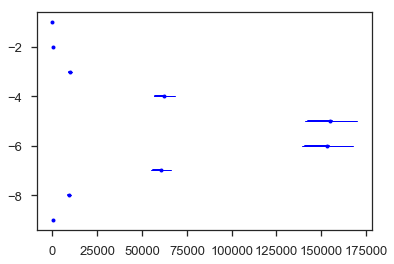

In [151]:
Matplot.summary_plot(model_june.M_0, custom_labels=age_group.categories)

In [152]:
june_r = pd.DataFrame({'local': model_june.trace('R_t_local')[:, -1],
                             'total': model_june.trace('R_t')[:, -1]})
june_r['Month'] = 'June'
june_r['Confirmation'] = 'Lab'

june_noconf_r = pd.DataFrame({'local': model_june_noconf.trace('R_t_local')[:, -1],
                             'total': model_june_noconf.trace('R_t')[:, -1]})
june_noconf_r['Month'] = 'June'
june_noconf_r['Confirmation'] = 'Clinical'

july_r = pd.DataFrame({'local': model_july.trace('R_t_local')[:, -1],
                             'total': model_july.trace('R_t')[:, -1]})
july_r['Month'] = 'July'
july_r['Confirmation'] = 'Lab'

july_noconf_r = pd.DataFrame({'local': model_july_noconf.trace('R_t_local')[:, -1],
                             'total': model_july_noconf.trace('R_t')[:, -1]})
july_noconf_r['Month'] = 'July'
july_noconf_r['Confirmation'] = 'Clinical'

In [153]:
r_estimates = pd.concat([june_r, june_noconf_r, july_r, july_noconf_r], 
                     ignore_index=True)

r_estimates.to_csv('output/r_estimates.csv')

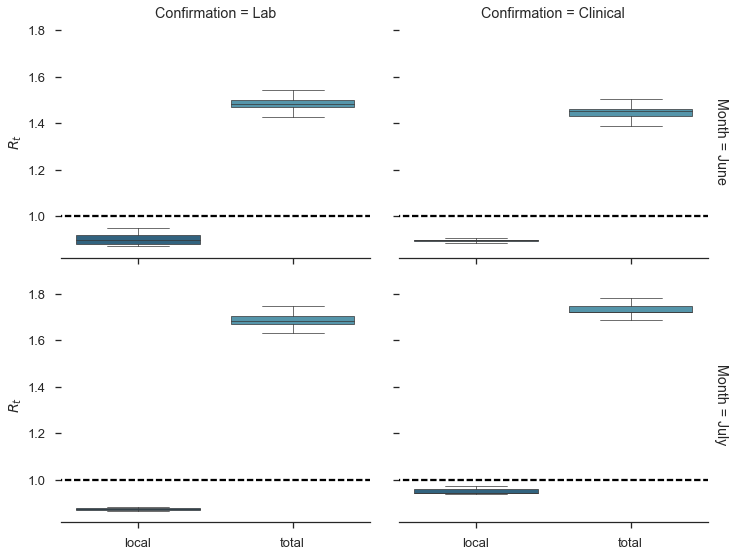

In [154]:
g = sns.factorplot(row="Month", col="Confirmation", data=r_estimates, kind='box',
              row_order=['June', 'July'],
              order=['local', 'total'], margin_titles=True,
            palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)
g.set_ylabels(r"$R_t$")
for ax in g.axes.ravel():
    ax.hlines(1, -1, 2, linestyles='dashed')

## Removing augmentation of migrant population

In [154]:
model_june_nomigrant = MCMC(measles_model('1997-06-15', migrant=False))

In [ ]:
model_june_nomigrant.sample(n_iterations, n_burn)

Plotting R0


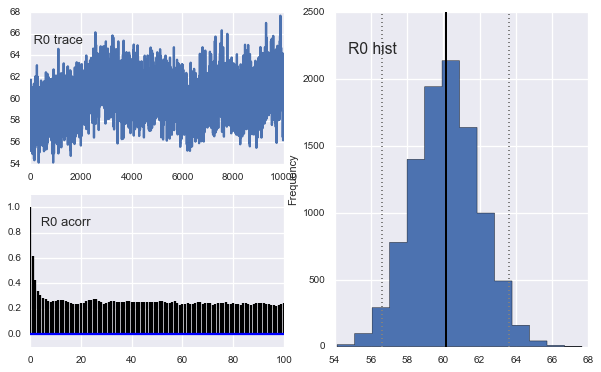

In [156]:
Matplot.plot(model_june_nomigrant.R0)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


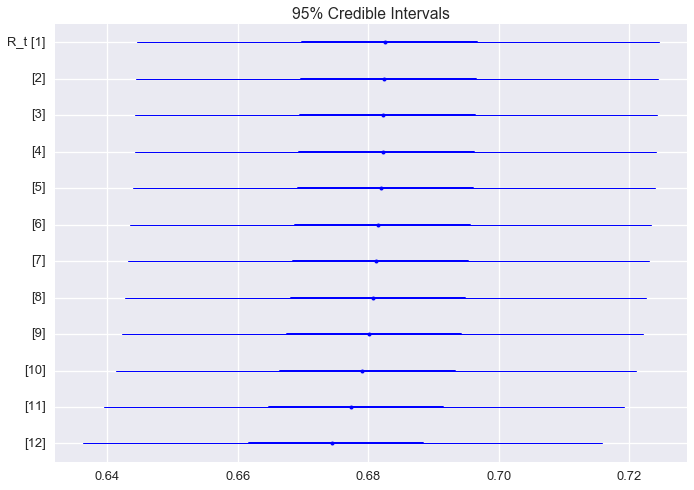

In [157]:
Matplot.summary_plot(model_june_nomigrant.R_t)